In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime

In [2]:
users_df = pd.read_csv("dataset/users.csv")

# Data Understanding and Preparation

## Users Data

In [3]:
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5 MB


### Attribute type and quality

In the **user** dataset there are 6 columns:

1. The id **column** seems to be ok, all values are integer and there are not null values, we have to check possible duplicates
 
2. We have 1 null value in the **name** column, we also assume that the name could be a string, a number or a special character, the names are not necessarily unique, but maybe it's intresting to check the frequency distribution.

3. In the **lang** column we don't have null values, but we have to check whether there are problems in the pattern used to express the language, we expect a categorical attribute 

4. The **bot** column is numerical as expected (binary), we have to check whether all the numbers are 0 or 1

5. The attribute **created_at** has no null values, but we have to check the correctness of the date, both sintactic and semantic (not too far in the past or in the future)

6. The **status_count** column has 399 of null values, in the non-null values there would semm to be unexpected float

Let's verify the uniqueness of ids and names

In [4]:
print("Number of total IDs:", len(users_df["id"]))
print("Number of unique IDs:", len(pd.unique(users_df["id"])))
print("Number of total names:", len(users_df["name"]))
print("Number of unique names:", len(pd.unique(users_df["name"])))

freq = {}
for n in users_df['name']:
    if n in freq:
        freq[n] += 1
    else:
        freq[n] = 1

freq_list = [(n, freq[n]) for n in freq]
freq_list.sort(key = lambda x: x[1], reverse=True)

print(freq_list[:10])

Number of total IDs: 11508
Number of unique IDs: 11508
Number of total names: 11508
Number of unique names: 11361
[('Sara', 7), ('Teresa', 5), ('Carla', 5), ('Bia', 4), ('Anna', 4), ('Marzia', 4), ('Amanda', 4), ('maria', 4), ('Ariela', 4), ('Jenn', 3)]


All ids are unique!

As said before one name is null. 

It will be interesting to check if the duplicates names are often the same

Now let's check the lang column

In [5]:
pd.unique(users_df["lang"])  

array(['en', 'it', 'fr', 'ru', 'es', 'tr', 'en-gb', 'pt', 'nl', 'id',
       'zh-tw', 'ja', 'de', 'ko', 'en-AU', 'da', 'ar', 'en-GB',
       'Select Language...', 'zh-TW', 'zh-cn', 'pl', 'el', 'fil', 'sv',
       'xx-lc'], dtype=object)

The "lang" field is composed of [IETF language codes](https://en.wikipedia.org/wiki/IETF_language_tag). By selecting only the unique values it's possible to see that there are some erroneous values:
* "Select Language..." and "xx-lc" seems to be **default values**
* other values are not properly correct (e.g. "zh-cn" instead of "zh-CN")
We propose to check the most common language used by these 'erroneous values' users and provide them with a more fitting language attribute.

In [6]:
utils.repair_lang_attribute(users_df)
pd.unique(users_df["lang"])

array(['en', 'it', 'fr', 'ru', 'es', 'tr', 'en-GB', 'pt', 'nl', 'id',
       'zh-TW', 'ja', 'de', 'ko', 'en-AU', 'da', 'ar', 'zh-CN', 'pl',
       'el', 'fil-PH', 'sv'], dtype=object)

Since wrong values are just the 0.02% of the number of rows they are just dropped, while the other values are mapped to the correct ones.

The bot attribute is perfectly as expected, all non-null binary values

In [7]:
pd.unique(users_df["bot"])

array([1, 0], dtype=int64)

We observe that the created_at coloumn is recognized by pandas as an object, and not as a datetime as we would expect from this attribute. Clean created_at field, by converting string to datetime

In [8]:
# parsing string to datetime obj
users_df["created_at"] = pd.to_datetime(users_df["created_at"])

This should be the end of the data understanding and cleaning of the users database

--------------------------------------------------------------------------------------------------

 and checks if all the tweets were created after the first tweet published on twitter (so we don't have something strange like a tweet created in 01-01-1990)

In [9]:


# checks if all the users were created after the first tweet published on twitter (so we don't have something strange like a user created in 01-01-1990)
twitter_first_tweet_datetime = datetime(2006,3,21,12,50,0)
#string_to_datetime = lambda string: datetime.strptime(string, expected_format)
published_after_twitter_first_tweet = lambda x: x > twitter_first_tweet_datetime
all(map(published_after_twitter_first_tweet, users_df["created_at"]))


True

we could do a similar operation for the names, but people with the same name is not an error. For names it is more interesting to know how many values are missing in total.

In [10]:
def my_isnan(a):
    return a != a

def my_isempty(a):
    if a == "":
        return True


number_of_total_names = len(users_df["name"])
not_empty_or_missing_names = []
empty_or_missing_names = []
names_with_only_spaces = []

# iterate over all names looking for errors
for value in users_df["name"]:
    if my_isnan(value) or my_isempty(value): # name is nan or is_empty string
        #print(users_df["name"])
        #print(users_df["name"].index(value))
        empty_or_missing_names.append(value)
    if str(value).strip() == "":
            names_with_only_spaces.append(value)
            #users_df["name"].drop(index=value)
    elif not(my_isnan(value) or my_isempty(value)):
        #print(users_df["name"])
        #print(users_df["name"].index(value))
        not_empty_or_missing_names.append(value)
print(f" Number of total names = {number_of_total_names} vs total name values that are not NA or empty = {len(not_empty_or_missing_names)}")

"""
for value in users_df["name"]:
    if my_isnan(value) or my_isempty(value):
        #print(users_df["name"])
        #print(users_df["name"].index(value))
        empty_or_missing_names.append(value)
        #users_df["name"].drop(index=value)
    #else:
    #    not_empty_or_missing_names.append(value)
"""
print(f" Number of total names = {number_of_total_names} vs total name values that are NA or empty = {len(empty_or_missing_names)}")

#print(len(names_with_only_spaces))
#print(not_empty_or_missing_names)
#array_of_nan = np.isnan(users_df["name"])

#users_df["name"][1012]
#users_df["name"][0]
#empty_or_missing_names


 Number of total names = 11505 vs total name values that are not NA or empty = 11504


'\nfor value in users_df["name"]:\n    if my_isnan(value) or my_isempty(value):\n        #print(users_df["name"])\n        #print(users_df["name"].index(value))\n        empty_or_missing_names.append(value)\n        #users_df["name"].drop(index=value)\n    #else:\n    #    not_empty_or_missing_names.append(value)\n'

 Number of total names = 11505 vs total name values that are NA or empty = 1


bot: should be yes or no; maybe there are wrong values?

We expect the statuses count to be an integer, but pandas has interpreted it as a float. This is probably due to the presence of NaN values

In [33]:
for index in users_df[users_df["statuses_count"].notnull()].index:
	old_statuses_count = users_df.loc[index, "statuses_count"]
	users_df.loc[index, "statuses_count"] = int(old_statuses_count)

users_df.info()
users_df.head()
#tmp = users_df.dropna(subset=["statuses_count"])
#tmp.info()

# users_df["statuses_count"].astype(int, copy=True, errors="ignore")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11505 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11505 non-null  int64         
 1   name            11504 non-null  object        
 2   lang            11505 non-null  object        
 3   bot             11505 non-null  int64         
 4   created_at      11505 non-null  datetime64[ns]
 5   statuses_count  11106 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 887.2+ KB


,id,name,lang,bot,created_at,statuses_count
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085.0


In [12]:
#tweets_df = pd.read_csv("dataset/tweets.csv", usecols=["id", "user_id"]) # read only this two colums (saving space)
tweets_df = pd.read_csv("dataset/tweets.csv")

### Distribution of variables and statistics
Let's study them!

array([[<AxesSubplot: title={'center': 'statuses_count'}>]], dtype=object)

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

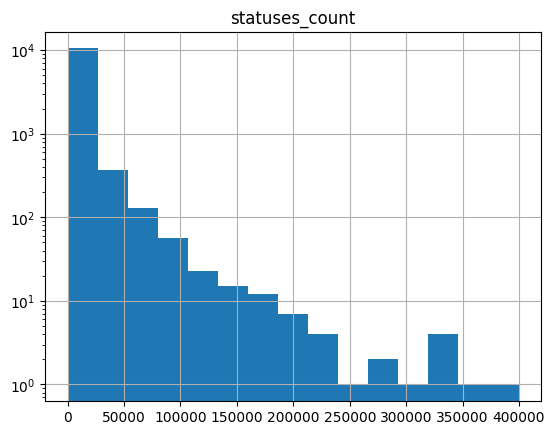

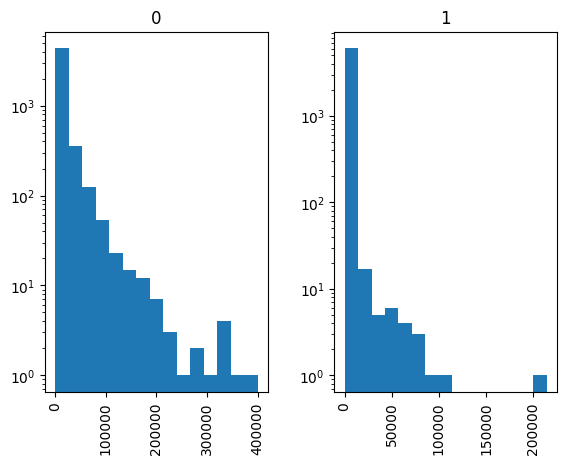

In [13]:
users_df.hist(
    column=["statuses_count"], 
    log=True, 
    bins=utils.get_sturges_bins(len(users_df["statuses_count"]))
)

users_df.hist(
    column=["statuses_count"], 
    by="bot", 
    log=True,
    bins=utils.get_sturges_bins(len(users_df["statuses_count"])) #FIX THIS: USES ALL THE SAMPLES, NOT JUST THE BOTS AND THE USERS
)

<AxesSubplot: xlabel='lang'>

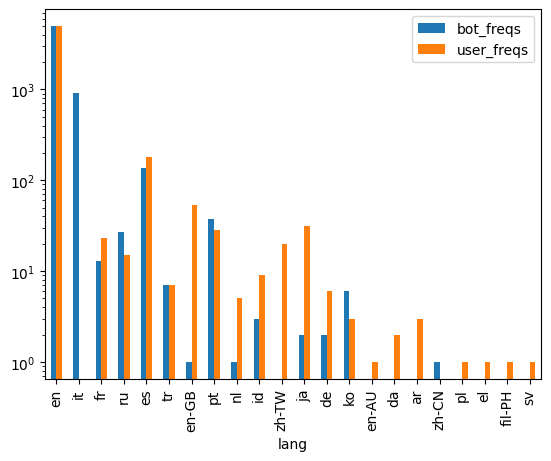

In [14]:
langs = pd.unique(users_df["lang"]) 
bot_freqs = []
user_freqs = []
for lang in langs:
    user_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 0")))
    bot_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 1")))
langs_df = pd.DataFrame({"lang": langs, "bot_freqs": bot_freqs, "user_freqs": user_freqs})
langs_df.plot.bar(x="lang", logy=True)

## Tweets data

### Assessing data quality

In [15]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              13664694 non-null  object
 1   user_id         13447413 non-null  object
 2   retweet_count   13227562 non-null  object
 3   reply_count     13016818 non-null  object
 4   favorite_count  13017154 non-null  object
 5   num_hashtags    12607172 non-null  object
 6   num_urls        13016073 non-null  object
 7   num_mentions    12810531 non-null  object
 8   created_at      13664696 non-null  object
 9   text            13126975 non-null  object
dtypes: object(10)
memory usage: 8.9 GB


In [16]:
tweets_df.isnull().any() 

id                 True
user_id            True
retweet_count      True
reply_count        True
favorite_count     True
num_hashtags       True
num_urls           True
num_mentions       True
created_at        False
text               True
dtype: bool

keeping only the tweets with user_id in user dataset

In [17]:
user_ids = users_df["id"].values
user_ids.dtype
parsed_user_ids = pd.to_numeric(tweets_df["user_id"], errors="coerce")
parsed_user_ids.dtype
tweets_df[parsed_user_ids.isin(user_ids)]

dtype('int64')

dtype('float64')

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
0,509354017856950272,327746321,0,0,0,0,0,0,2019-09-11 14:53:55,"If man is a little lower than angels, then ang..."
1,583002592529121280,333722906,1,0,0,0,0,1,2020-04-01 20:27:04,"""@BestWSHHVids: how do you say these words wit..."
2,461498835362013185,2379755827,0,0,0,0,0,1,2019-05-02 13:34:31,@LOLatComedy awsome
3,528808127366692864,466226882,0,0,0,0,0,0,2019-11-04 07:17:37,Stephen Hawkins: i buchi neri non esistono se ...
4,575336690904006656,1355537995,114,0,0,1,0,1,2020-03-11 16:45:31,RT @tibbs_montris: So ready for Wednesday!
...,...,...,...,...,...,...,...,...,...,...
13664691,588535254207467520,587491046,0,0,0,0,0,1,2020-04-17 02:51:53,"@warriors Congrats, maybe I'll be able to get ..."
13664692,580420653666402304,1414080518,0,0,1,0,0,1,2020-03-25 17:27:22,@DaddieEzme fr??
13664693,718157017970961,91781300,0,NaN,l25suv5,NaN,0.0,NaN,2016-07-10 22:43:09,NaN
13664694,441301348676415488,127895572,0,0,1,1,0,0,2019-03-07 19:56:55,Shooting crew of porn movies. #TheWorstJobToHave


clean id field by first removing nan values (just 2), then tring to cast to int and removing duplicates

In [18]:
#tweets_df.dropna(subset=["id"], inplace=True)

# removing not numeric strings
#pd.to_numeric(tweets_df["id"])

#tweets_df["id"].isin(users)

From the method above we observe that all our atributes except for "created_at" have one or more elements with null values.

In [19]:
"""
wrong_ids = []
for (i,k) in enumerate(df["id"]):
    if not isinstance(k, str) or not k.isnumeric():
        wrong_ids.append(i)
print(len(wrong_ids)/len(df["id"]))
""" 

'\nwrong_ids = []\nfor (i,k) in enumerate(df["id"]):\n    if not isinstance(k, str) or not k.isnumeric():\n        wrong_ids.append(i)\nprint(len(wrong_ids)/len(df["id"]))\n'

### Distribution of variables and statistics
Let's study them!

In [20]:
# should we use sturgen rule for number of bins?

# give error: ValueError: hist method requires numerical or datetime columns, nothing to plot.
#tweets_df.hist(column=["reply_count","retweet_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"])

In [21]:
tweets_df.describe()

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
count,13664694,13447413,13227562,13016818,13017154,12607172,13016073,12810531,13664696,13126975
unique,11672135,222285,229167,158619,158763,104779,157145,131538,8127084,6778478
top,dmy,497404180,0,0,0,0,0,0,2020-04-04 03:43:02,"Ci sedemmo dalla parte del torto, visto che tu..."
freq,14,4600,9419784,11790440,9467209,10470209,9894198,7561627,133,6932


### Variables trasformations (?)

### Pairwise correlations